In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from numpy import concatenate
from math import sqrt
import matplotlib as mpl
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = True

In [0]:
data = pd.read_csv('./allYearLabeledHarangi.csv', header=0,parse_dates=True, index_col=0)

In [17]:
data=data.drop(columns = ['Present Storage(TMC)', 'Reservoir Level(TMC)', 'Outflow'])
print(data.head(5))

            Inflow  MADIKERI  SOMWARPET  VIRAJPET  Label
Dates                                                   
2011-01-01   142.0       0.0        0.0       0.0      4
2011-01-02   239.0       0.0        0.0       0.0      0
2011-01-03   166.0       0.0        0.0       0.0      3
2011-01-04   118.0       0.0        0.0       0.0      3
2011-01-05   130.0       0.0        0.0       0.0      0


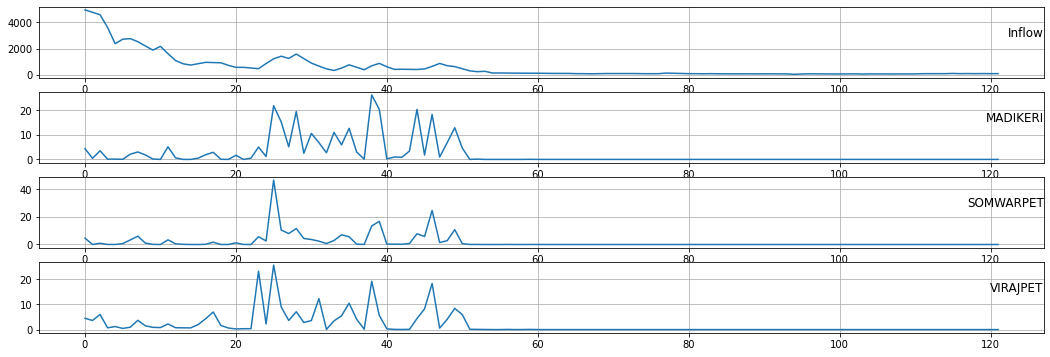

In [18]:
# load dataset
dataset = data#pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[2800:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [0]:
def sense_val_inflow(df):
    sense_vals = []
    for x in df['Inflow']:
        if(x <= 1000):
            sense_vals.append(float(0))
        # if((x > 500) and (x <= 1000)):
        #     sense_vals.append(float(3))
        if((x > 1000) and (x <= 2500)):
            sense_vals.append(float(1))
        if((x > 2500) and (x <= 5000)):
            sense_vals.append(float(2))
        if((x > 5000) and (x <= 11000)):
            sense_vals.append(float(3))
        if((x > 11000) and (x <= 20000)):
            sense_vals.append(float(4))
        if((x > 20000) and (x <= 30000)):
            sense_vals.append(float(5))
        if((x > 30000) and (x <= 40000)):
            sense_vals.append(float(6))
        if((x > 40000) and (x <= 50000)):
            sense_vals.append(float(7))
        if((x > 50000) and (x <= 70000)):
            sense_vals.append(float(8))
        # if((x > 12000) and (x <= 16000)):
        #     sense_vals.append(float(13))
        # if((x > 16000) and (x <= 25000)):
        #     sense_vals.append(float(14))
        # if((x > 25000) and (x <= 40000)):
        #     sense_vals.append(float(15))
        if(x > 70000):
            sense_vals.append(float(9))
    return sense_vals

In [0]:
dataset['Label']=sense_val_inflow(dataset)

In [53]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
# dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values, 4, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
# reframed.drop(reframed.columns[[-2,-3,-4,-5]], axis=1, inplace=True)
reframed.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
4,142.0,0.0,0.0,0.0,0.0,239.0,0.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0
5,239.0,0.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0
6,166.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,0.0
7,118.0,0.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,0.0,131.0,0.0,0.0,0.0,0.0
8,130.0,0.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,0.0,131.0,0.0,0.0,0.0,0.0,112.0,0.0,0.0,0.0,0.0


In [54]:
reframed.drop(reframed.columns[[4,9,14,19,-2,-3,-4,-5]], axis=1, inplace=True)
reframed.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t)
4,142.0,0.0,0.0,0.0,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,0.0
5,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0
6,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0
7,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,0.0
8,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,131.0,0.0,0.0,0.0,0.0


In [55]:
reframed['var5(t)'] = reframed['var5(t)'].apply(pd.to_numeric)
values = reframed.values
y=values[:,-1]
yset = to_categorical(y)
n_hours = 4
n_features = 4
n_train_days = 365 * 7
# train = values[:n_train_days, :]
# test = values[n_train_days:, :]
n_obs = n_hours * n_features
train_X, train_y = values[:n_train_days, :n_obs],yset[:n_train_days,:]
test_X, test_y = values[n_train_days:, :n_obs], yset[n_train_days:, :]
print(train_X.shape, len(train_X), train_y.shape)
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2555, 16) 2555 (2555, 10)
(2555, 4, 4) (2555, 10) (363, 4, 4) (363, 10)


In [0]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 70, 20
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(40, input_shape=(n_timesteps,n_features)))
#     model.add(Dropout(0.08))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
#     pyplot.plot(history.history['loss'], label='train')
#     pyplot.plot(history.history['val_loss'], label='test')
#     pyplot.legend()
#     pyplot.show()
 # evaluate model
    _,accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    xxx=model.predict(testX)
    return accuracy,xxx
    
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [0]:
def run_experiment(repeats=10):
	# load data
    # trainX, trainy, testX, testy = 
	# repeat experiment
    scores = list()
    for r in range(repeats):
        score,xxx = evaluate_model(train_X, train_y, test_X, test_y)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    return xxx

In [57]:
xxx=run_experiment(5)

# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

>#1: 82.645
>#2: 75.758
>#3: 82.094
>#4: 83.196
>#5: 80.716
[82.64462947845459, 75.75757503509521, 82.09366202354431, 83.19559097290039, 80.71625232696533]
Accuracy: 80.882% (+/-2.691)


In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [63]:
print(recall_m(test_y,xxx))
print(precision_m(test_y,xxx))
print(f1_m(test_y,xxx))


tf.Tensor(0.7630854, shape=(), dtype=float32)
tf.Tensor(0.938983, shape=(), dtype=float32)
tf.Tensor(0.84194523, shape=(), dtype=float32)


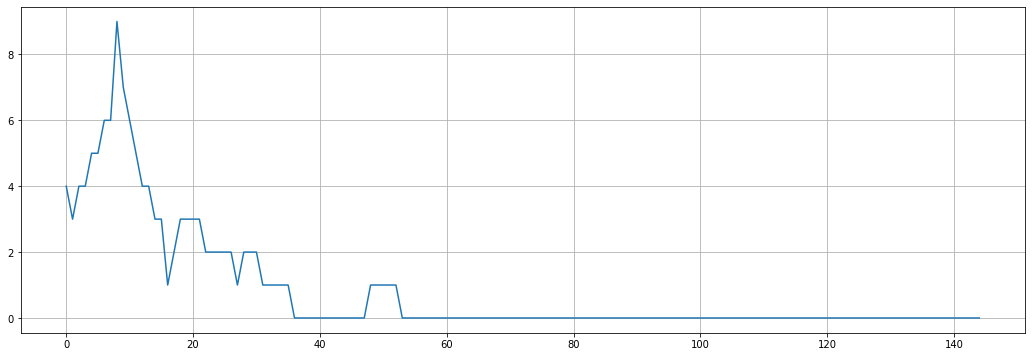

In [70]:
pyplot.plot(values[(365*7)+218:,-1])

In [76]:
values[(365*7)+226,-1]

9.0

In [77]:
test_y[226]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [78]:
xxx[226]

array([6.2903473e-03, 2.1338789e-01, 4.0715122e-01, 3.1151408e-01,
       5.8700886e-02, 2.9415507e-03, 2.7364688e-06, 4.2743181e-06,
       4.8096099e-06, 2.2366144e-06], dtype=float32)

In [0]:
from scipy.special import softmax
np.set_printoptions(precision=5)
m=softmax(xxx[226])

In [80]:
m.sum()

0.99999994

In [81]:
m

array([0.09005, 0.11076, 0.13445, 0.12218, 0.09489, 0.08974, 0.08948,
       0.08948, 0.08948, 0.08948], dtype=float32)